![Alt text](image.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



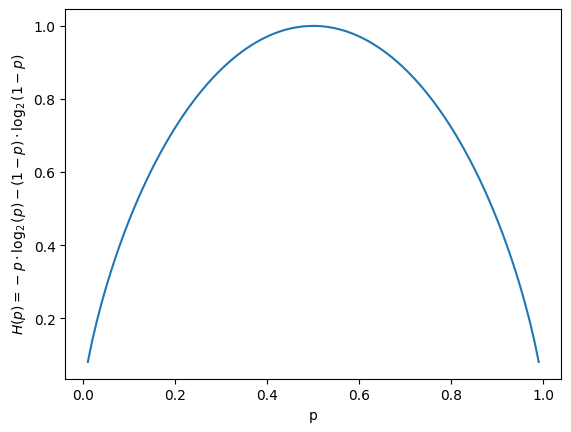

In [3]:
p = np.linspace(0.01, 0.99, 100)
H = -p*np.log2(p) - (1-p)*np.log2(1-p)

plt.plot(p, H)
plt.xlabel('p')
plt.ylabel(r'$H(p) = -p \cdot \log_2(p) - (1-p) \cdot \log_2(1-p)$')
plt.show()


![Alt text](image-1.png)

Lo hacemos mediante el dataset de hojas que recolectamos


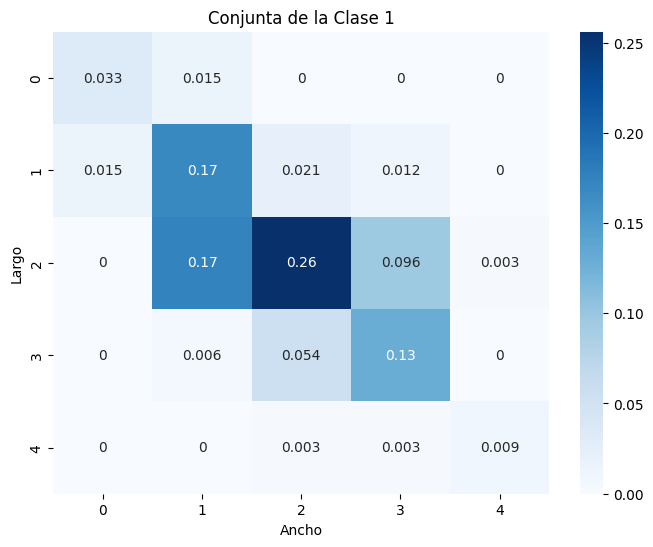

In [4]:
def cuantizacion( data, steps = 20):
    """
    Cuantización del vector <data> en <steps> niveles.
    """
    if steps < 2:
        steps = 2
    bins = np.arange(0.0,1.0+(1/steps), 1/steps)
    bins = (np.max(data)-np.min(data))*bins + np.min(data) #determina los límites de cada bin-
    bins = bins[1:-1]
    return np.digitize(data,bins)

# Leer el archivo CSV
data = pd.read_csv('datasetHojas.csv', sep=',')
data_clase1 = data[data['Clase'] == 'C1']
data_clase2 = data[data['Clase'] == 'C2']

# Separar los datos de cada clase
largo_clase1 = data_clase1['Largo']
ancho_clase1 = data_clase1['Ancho']
largo_clase2 = data_clase2['Largo']
ancho_clase2 = data_clase2['Ancho']

# Matriz de contingencia entre las variables Largo y Ancho
#hacer la cuantización de los datos para trabajar en un dominio acotado
bins = 5
largo_clase1 = cuantizacion(largo_clase1, steps=bins)
ancho_clase1 = cuantizacion(ancho_clase1, steps=bins)

largo_clase2 = cuantizacion(largo_clase2, steps=bins)
ancho_clase2 = cuantizacion(ancho_clase2, steps=bins)

#conjunta entre anchos y largos de clase 1
contingency_matrix_1 = pd.crosstab(largo_clase1, ancho_clase1)
total_frequencies_1 = contingency_matrix_1.values.sum()
jointWLC1 = contingency_matrix_1 / total_frequencies_1
#conjunta entre anchos y largos de clase 2
contingency_matrix_2 = pd.crosstab(largo_clase2, ancho_clase2)
total_frequencies_2 = contingency_matrix_2.values.sum()
jointWLC2 = contingency_matrix_2 / total_frequencies_2
#conjunta entre anchos de clase 1 y 2
sub_ancho_clase1 = ancho_clase1[:len(ancho_clase2)]
contingency_matrix_3 = pd.crosstab(sub_ancho_clase1, ancho_clase2)
total_frequencies_3 = contingency_matrix_3.values.sum()
jointWW = contingency_matrix_3 / total_frequencies_3

#plot la conjunta con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(jointWLC1, annot=True, cmap='Blues', label='Clase 1')
plt.xlabel('Ancho')
plt.ylabel('Largo')
plt.title('Conjunta de la Clase 1')
plt.show()


In [5]:
#joint_entropy 
def joint_entropy(joint_probability):
    joint_entropy = 0
    for i in range(len(joint_probability)):
        for j in range(len(joint_probability[i])):
            if joint_probability[i][j] != 0:
                joint_entropy += joint_probability[i][j] * np.log2(joint_probability[i][j])
    return -joint_entropy

# Calcular la entropía conjunta para la Clase 1 y la Clase 2
joint_entropy_1 = joint_entropy(jointWLC1.values)
joint_entropy_2 = joint_entropy(jointWLC2.values)
print("Entropía conjunta para la Clase 1: ", joint_entropy_1)
print("Entropía conjunta para la Clase 2: ", joint_entropy_2)
print("Bins por cada variable (ancho, largo): ", bins)


Entropía conjunta para la Clase 1:  3.0321465454645993
Entropía conjunta para la Clase 2:  2.853608585978931
Bins por cada variable (ancho, largo):  5


Luego calculamos la entropía condicional, sabiendo que condicionar implica bajar la entropía.

![Alt text](image-3.png)

In [6]:
#Compute the conditional entropy H(Y|X)

def conditional_distributionYX(joint_probability):
    conditional_distribution = np.zeros((len(joint_probability), len(joint_probability[0])))
    for i in range(len(joint_probability)):
        for j in range(len(joint_probability[i])):
            conditional_distribution[i][j] = joint_probability[i][j] / np.sum(joint_probability[i])
    return conditional_distribution

def conditional_entropyYX(joint_probability, conditional_distribution):
    conditional_entropy = 0
    for i in range(len(joint_probability)):
        for j in range(len(joint_probability[i])):
            if conditional_distribution[i][j] != 0:
                conditional_entropy += joint_probability[i][j] * np.log2(conditional_distribution[i][j])
    return -conditional_entropy

conditional_distribution_1 = conditional_distributionYX(jointWLC1.values)
conditional_distribution_2 = conditional_distributionYX(jointWLC2.values)

conditional_entropy_1 = conditional_entropyYX(jointWLC1.values, conditional_distribution_1)
conditional_entropy_2 = conditional_entropyYX(jointWLC2.values, conditional_distribution_2)

print("Entropía condicional para la Clase 1 (H(largo|ancho)): ", conditional_entropy_1)
print("Entropía condicional para la Clase 2 (H(largo|ancho)): ", conditional_entropy_2)


    
    


Entropía condicional para la Clase 1 (H(largo|ancho)):  1.3115433811024402
Entropía condicional para la Clase 2 (H(largo|ancho)):  1.1251274508998534


se verifica que $H(X,Y) = H(X) + H(Y|X)$

In [7]:
def marginal_entropy(marginal_probability):
    marginal_entropy = 0
    for i in range(len(marginal_probability)):
        if marginal_probability[i] != 0:
            marginal_entropy += marginal_probability[i] * np.log2(marginal_probability[i])
    return -marginal_entropy

margin_entropy_1 = marginal_entropy(jointWLC1.sum(axis=1))
sum_entropy_1 = margin_entropy_1 + conditional_entropy_1

print("La suma de las entropías marginales es: ", sum_entropy_1)

La suma de las entropías marginales es:  3.032146545464599


Si son independientes $X$ e $Y$ se verifica que $H(X,Y) = H(X) + H(Y)$. Para ello, lo probaremos entre anchos de diferentes clases.

In [8]:
#submuestrear el largo de la clase 1
largo_clase1 = largo_clase1[:len(largo_clase2)]


contingency_matrix_1 = pd.crosstab(largo_clase1, largo_clase2)
total_frequencies_1 = contingency_matrix_1.values.sum() 

jointWLC1 = contingency_matrix_1 / total_frequencies_1

joint_entropy_1 = joint_entropy(jointWLC1.values)

margin_entropy_1 = marginal_entropy(jointWLC1.sum(axis=1))

margin_entropy_2 = marginal_entropy(jointWLC1.sum(axis=0))

print("La entropía conjunta es: ", joint_entropy_1)
print("La entropía marginal es: ", margin_entropy_1 + margin_entropy_2)

La entropía conjunta es:  3.248302383574812
La entropía marginal es:  3.308460533440527


## Información Mutua

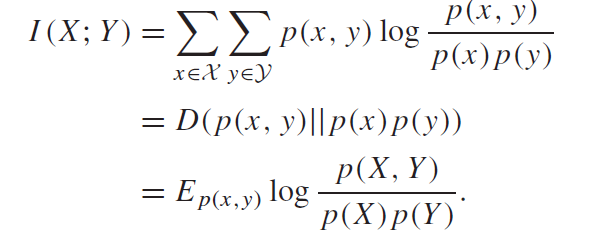

Sacamos la información mutua entre el ancho de la clase 1 y clase 2

In [9]:
def mutualInformation(joint_probability, marginal_probability1, marginal_probability2):
    mutual_information = 0
    for i in range(len(joint_probability)):
        for j in range(len(joint_probability[i])):
            if joint_probability[i][j] != 0:
                mutual_information += joint_probability[i][j] * np.log2(joint_probability[i][j] / (marginal_probability1[i] * marginal_probability2[j]))
    return mutual_information

#mutual information beetween anchos
mutual_information_1 = mutualInformation(jointWW.values, jointWW.sum(axis=1), jointWW.sum(axis=0))
print("La información mutua entre anchos es: ", mutual_information_1)



La información mutua entre anchos es:  0.06383757080629111


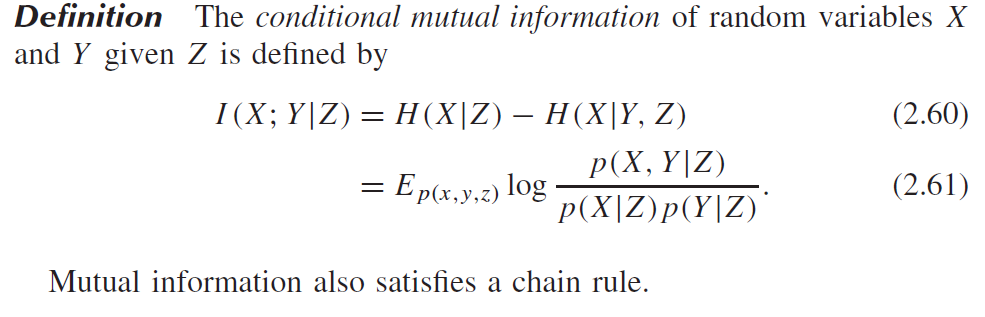

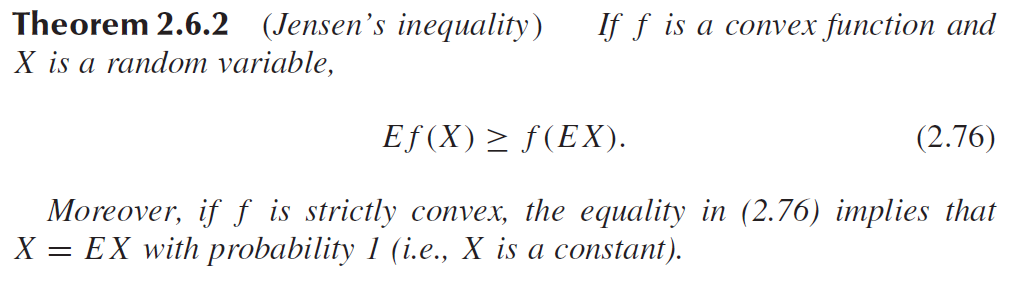

Lo que queremos ver es que sucede cuando a nuestras muestras le aplicamos una función que es convexa

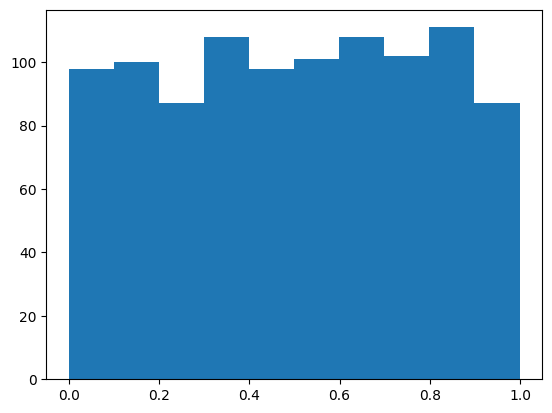

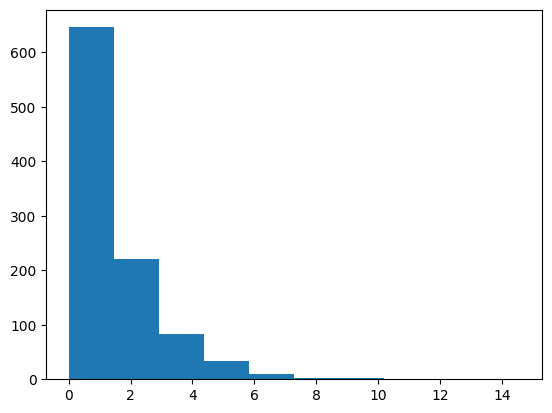

E(-log2(x)):  1.4356614245365242
-log2 E(x)):  0.9944590950465924
La desigualdad de Jensen se cumple: E[f(x)] >= f(E[X]) --> E(-log2(x)) >= -log2 E(x)


In [19]:
x = np.random.uniform(0, 1, 1000)
logx = - np.log2(x)
bineado = 10

plt.hist(x, bins=bineado)
plt.show()

plt.hist(logx, bins=bineado)
plt.show()

Elogx = np.mean(logx)
LogEX = -np.log2(np.mean(x))

print("E(-log2(x)): ", Elogx)
print("-log2 E(x)): ", LogEX)

if Elogx >= LogEX:
    print("La desigualdad de Jensen se cumple: E[f(x)] >= f(E[X]) --> E(-log2(x)) >= -log2 E(x)")

